In [1]:
# import
import os
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

# import nctpy functions
from nctpy.energies import integrate_u, get_control_inputs
from nctpy.pipelines import ComputeControlEnergy, ComputeOptimizedControlEnergy
from nctpy.metrics import ave_control
from nctpy.utils import matrix_normalization, convert_states_str2int, \
    normalize_state, normalize_weights, get_null_p, get_fdr_p
from nctpy.plotting import roi_to_vtx, null_plot, surface_plot, add_module_lines
from null_models.geomsurr import geomsurr

# Protocol Pathway A: Control Energy

### Load A

In [2]:
# directory where data is stored
datadir = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/nctpy/data'
resultsdir = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/nctpy/results'
A_file = 'pnc_schaefer200_Am.npy'

In [3]:
# load A matrix
A = np.load(os.path.join(datadir, A_file))
n_nodes = A.shape[0]
print(A.shape)

# check for self-connections
print(np.any(np.diag(A) > 0))

# get density including self connections
A_d = np.count_nonzero(np.triu(A, k=0)) / (n_nodes ** 2 / 2)
print(A_d)

(200, 200)
True
0.9768


### Normalize A

In [4]:
# normalize
system = 'continuous'
A_norm = matrix_normalization(A, system=system, c=1)

### Get initial and target state

In [5]:
# load node-to-system mapping
system_labels = list(np.loadtxt(os.path.join(datadir, 'pnc_schaefer200_system_labels.txt'), dtype=str))

In [6]:
print(len(system_labels))
print(system_labels[:20])

200
['Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot']


In [7]:
# use list of system names to create states
states, state_labels = convert_states_str2int(system_labels)

In [8]:
print(type(state_labels), len(state_labels))
print(state_labels)

<class 'list'> 7
['Cont', 'Default', 'DorsAttn', 'Limbic', 'SalVentAttn', 'SomMot', 'Vis']


In [9]:
print(type(states), states.shape)
print(states)

<class 'numpy.ndarray'> (200,)
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2
 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 4
 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [10]:
# extract initial state
x0 = states == state_labels.index('Vis')
# x0 = states == state_labels.index('Default')

# extract target state
xf = states == state_labels.index('Default')

# strength of states
s = np.sum(A, axis=0)
print('x0 strength: {0}'.format(np.mean(s[x0])))
print('xf strength: {0}'.format(np.mean(s[xf])))
bystanders = x0 + xf
bystanders = ~bystanders
print('remaining nodes: {0}'.format(np.mean(s[bystanders])))

x0 strength: 67773.32556141318
xf strength: 59454.519733095905
remaining nodes: 53761.60911578159


In [11]:
# normalize state magnitude
x0 = normalize_state(x0)
xf = normalize_state(xf)

['Cont' 'Default' 'DorsAttn' 'Limbic' 'SalVentAttn' 'SomMot' 'Vis']


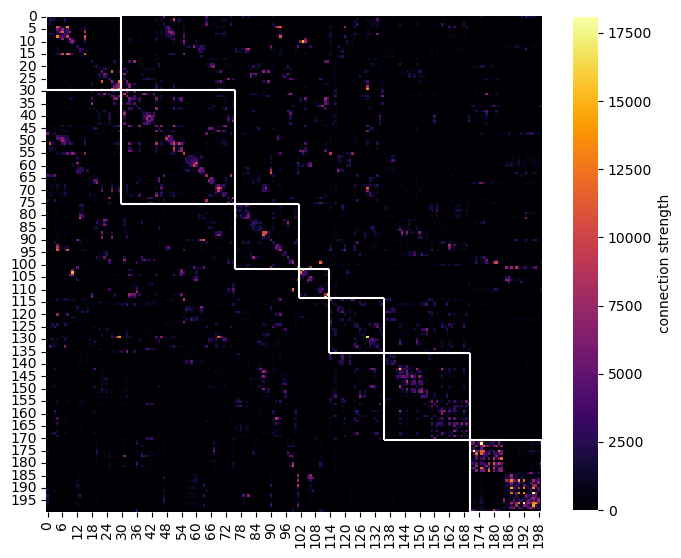

In [12]:
# plot A matrix
sl = pd.Series(system_labels)
sl.sort_values(ascending=True, inplace=True)
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(A[sl.index, :][:, sl.index], ax=ax, square=True, cmap='inferno',
            cbar_kws={'label': 'connection strength', 'shrink': 0.8})
add_module_lines(sl, ax)
f.savefig(os.path.join(resultsdir, 'A.png'), dpi=600, bbox_inches='tight', pad_inches=0.01)
plt.show()

### Setup control nodes and weights

In [13]:
# helper func for printing descriptive stats
def print_stats(x):
    print('min={:.2f}; max={:.2f}; mean={:.2f}; std={:.2f}; skew={:.2f}; kurt={:.2f}'
      .format(np.min(x), np.max(x),
              np.mean(x), np.std(x),
              sp.stats.skew(x), sp.stats.kurtosis(x)
          ))

In [14]:
# define a control set
which_control_set = 'uniform_full'

if which_control_set == 'uniform_full':
    # specify a uniform full control set: all nodes are control nodes
    # and all control nodes are assigned equal control weight
    B = np.eye(n_nodes)
elif which_control_set == 'uniform_partial':
    # specify a uniform partial control set: some nodes are control nodes
    # and all control nodes are assigned equal control weight
    bystanders = np.logical_and(x0 == 0, xf == 0)  # use x0 and xf to find bystanders
    # note, this only works for binary states.
    B = np.zeros((n_nodes, n_nodes))  # initialize B matrix
    B[bystanders, bystanders] = 1  # set bystanders to control nodes

    # control nodes: x0
    # B = np.zeros((n_nodes, n_nodes))
    # B[x0 != 0, x0 != 0] = 1
    # B[x0 == 0, x0 == 0] = 1e-5  # add a little bit of control to remaining nodes

    # control nodes: xf
    # B = np.zeros((n_nodes, n_nodes))
    # B[xf != 0, xf != 0] = 1
    # B[xf == 0, xf == 0] = 1e-5  # add a little bit of control to remaining nodes
elif which_control_set == 'neuromap':
    neuromap_file = 'schaefer200_cyto.npy'
    neuromap = np.load(os.path.join(datadir, neuromap_file))
    print(neuromap.shape)
    print_stats(neuromap)

    # modify neuromap so that its minimum value is 1
    neuromap += 1 + np.abs(np.min(neuromap))
    print_stats(neuromap)

    B = np.zeros((n_nodes, n_nodes))  # initialize B matrix
    B[np.diag_indices(n_nodes)] = neuromap  # set weights using neuromap

    # plot neuromap on brain surface
    lh_annot_file = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/connectome_loader/data/schaefer_parc/' \
                    'fsaverage5/lh.Schaefer2018_200Parcels_7Networks_order.annot'
    rh_annot_file = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/connectome_loader/data/schaefer_parc/' \
                    'fsaverage5/rh.Schaefer2018_200Parcels_7Networks_order.annot'
    fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')

    f = surface_plot(data=neuromap,
                     lh_annot_file=lh_annot_file, rh_annot_file=rh_annot_file,
                     fsaverage=fsaverage, order='lr', cmap='viridis')
    f.savefig(os.path.join(resultsdir, 'neuromap.png'), dpi=600, bbox_inches='tight', pad_inches=0.01)

In [15]:
# compare two annotation maps
if which_control_set == 'neuromap':
    neuromap_file_1 = 'schaefer200_cyto.npy'
    neuromap_1 = np.load(os.path.join(datadir, neuromap_file_1))
    neuromap_1_norm = normalize_weights(neuromap_1)

    neuromap_file_2 = 'schaefer200_micro.npy'
    neuromap_2 = np.load(os.path.join(datadir, neuromap_file_2))
    neuromap_2_norm = normalize_weights(neuromap_2)

    print_stats(neuromap)
    print_stats(neuromap_1_norm)
    print_stats(neuromap_2)
    print_stats(neuromap_2_norm)

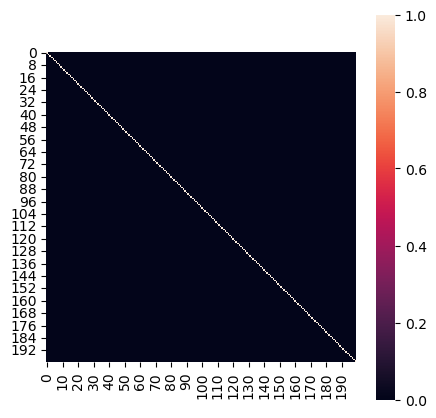

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


In [16]:
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(B, ax=ax, square=True)
plt.show()
print(B.diagonal())

In [17]:
# set parameters
T = 1 # time horizon
rho = 1 # mixing parameter for state trajectory constraint
S = np.eye(n_nodes) # nodes in state trajectory to be constrained

# get the state trajectory (x) and the control inputs (u)
x, u, n_err = get_control_inputs(A_norm=A_norm, T=T, B=B, x0=x0, xf=xf,
                                 system=system, rho=rho, S=S)

# print errors
thr = 1e-8

# the first numerical error corresponds to the inversion error
print('inversion error = {:.2E} (<{:.2E}={:})'
      .format(n_err[0], thr, n_err[0] < thr))

# the second numerical error corresponds to the reconstruction error
print('reconstruction error = {:.2E} (<{:.2E}={:})'
      .format(n_err[1], thr, n_err[1] < thr))

inversion error = 1.36E-15 (<1.00E-08=True)
reconstruction error = 5.16E-14 (<1.00E-08=True)


### Plot x and u

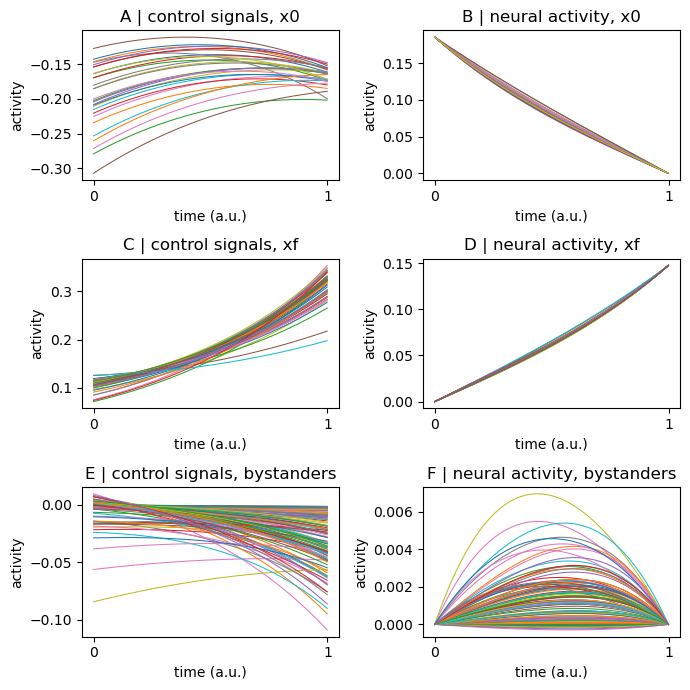

In [18]:
f, ax = plt.subplots(3, 2, figsize=(7, 7))
# plot control signals for initial state
ax[0, 0].plot(u[:, x0 != 0], linewidth=0.75)
ax[0, 0].set_title('A | control signals, x0')
# plot state trajectory for initial state
ax[0, 1].plot(x[:, x0 != 0], linewidth=0.75)
ax[0, 1].set_title('B | neural activity, x0')

# plot control signals for target state
ax[1, 0].plot(u[:, xf != 0], linewidth=0.75)
ax[1, 0].set_title('C | control signals, xf')
# plot state trajectory for target state
ax[1, 1].plot(x[:, xf != 0], linewidth=0.75)
ax[1, 1].set_title('D | neural activity, xf')

# plot control signals for bystanders
ax[2, 0].plot(u[:, np.logical_and(x0 == 0, xf == 0)], linewidth=0.75)
ax[2, 0].set_title('E | control signals, bystanders')
# plot state trajectory for bystanders
ax[2, 1].plot(x[:, np.logical_and(x0 == 0, xf == 0)], linewidth=0.75)
ax[2, 1].set_title('F | neural activity, bystanders')

for cax in ax.reshape(-1):
    cax.set_ylabel("activity")
    cax.set_xlabel("time (a.u.)")
    cax.set_xticks([0, x.shape[0]])
    cax.set_xticklabels([0, T])

f.tight_layout()
f.savefig(os.path.join(resultsdir, 'plot_xu.svg'), dpi=600, bbox_inches='tight', pad_inches=0.01)
plt.show()

### Compute control energy

In [19]:
# integrate control inputs to get control energy
node_energy = integrate_u(u)
print(node_energy.shape)
print(np.round(node_energy[:5], 2))

# summarize nodal energy
energy = np.sum(node_energy)
print(np.round(energy, 2))
print('{:.2E}'.format(np.round(energy, 2)))

(200,)
[21.13 37.65 23.55 21.55 28.34]
2604.71
2.60E+03


## Variant: data-driven optimization of control weights

In [20]:
if which_control_set == 'uniform_full':
    # container for perturbed energies
    energy_perturbed = np.zeros(n_nodes)

    for i in tqdm(np.arange(n_nodes)):
        # start with a uniform full control set
        B_p = np.eye(n_nodes)

        # add arbitrary amount of additional control to node i
        B_p[i, i] += 0.1

        # get perturbed control inputs (u_p)
        _, u_p, _ = get_control_inputs(A_norm=A_norm, T=T, B=B_p, x0=x0, xf=xf, system=system, rho=rho, S=S)

        # integrate control inputs to get control energy
        node_energy_perturbed = integrate_u(u_p)

        # summarize nodal energy
        energy_perturbed[i] = np.sum(node_energy_perturbed)

    # check if perturbed energy is lower than original energy. Should print True
    print(np.all(energy_perturbed < energy))

    # calculate energy delta. these values will all be negative,
    # indicating reduced energy compared to B=np.eye(n_nodes)
    energy_delta = energy_perturbed - energy

100%|██████████| 200/200 [00:08<00:00, 24.50it/s]

True


In [21]:
if which_control_set == 'uniform_full':
    # re-compute energy using energy deltas as weights
    # we do this by taking a single step down the
    # gradient created by the energy deltas
    lr = 0.01  # set a learning rate for gradient descent
    B_o = np.zeros((n_nodes, n_nodes))  # initialize container for optimized weights
    B_o[np.diag_indices(n_nodes)] = 1 - energy_delta * lr  # step down gradient
    B_o = B_o / sp.linalg.norm(B_o) * sp.linalg.norm(B)  # normalize
    # normalization ensures that the optimized weights have the same
    # norm as B=np.eye(n_nodes)

    # get optimized control inputs (u_o)
    _, u_o, _ = get_control_inputs(A_norm=A_norm, T=T, B=B_o, x0=x0, xf=xf, system=system, rho=rho, S=S)

    # integrate control inputs to get control energy
    node_energy_optimized = integrate_u(u_o)

    print(np.round(node_energy_optimized[:5], 2))

    # summarize nodal energy
    energy_optimized = np.sum(node_energy_optimized)

    print(np.round(energy_optimized, 2))

[20.56 34.94 22.77 20.92 26.96]
2429.68


In [22]:
if which_control_set == 'uniform_full':
    control_task = dict()  # initialize dict
    control_task['x0'] = x0  # store initial state
    control_task['xf'] = xf  # store target state
    control_task['S'] = S  # store state trajectory constraints
    control_task['rho'] = rho  # store rho
    compute_opt_control_energy = ComputeOptimizedControlEnergy(A=A,
                                                               control_task=control_task,
                                                               system=system,
                                                               c=1,
                                                               T=1,
                                                               n_steps=2,
                                                               lr=0.01)
    compute_opt_control_energy.run()

    print(compute_opt_control_energy.E_opt.shape)
    print(compute_opt_control_energy.B_opt.shape)

Running gradient step 0


100%|██████████| 200/200 [00:08<00:00, 24.18it/s]


Running gradient step 1


100%|██████████| 200/200 [00:08<00:00, 24.34it/s]

(2,)
(2, 200)


## Effect of edge density

In [23]:
# for reproducibility
np.random.seed(0)

A_pruned = A.copy()
n_delete = 500

A_d_pruned = []
E_prune = []

A_d_p = A_d
while A_d_p > 0.1:
    for j in np.arange(n_delete):
        # find non-zero edges
        idx = np.where(A_pruned > 0)
        # randomly sample one non-zero edge
        id = np.random.randint(0, len(idx[0]), 1)
        # set edge to 0
        A_pruned[idx[0][id], idx[1][id]] = 0
        A_pruned[idx[1][id], idx[0][id]] = 0

    # normalize pruned A
    A_prune_norm = matrix_normalization(A_pruned, system=system, c=1)
    # get control inputs
    _, u_pruned, _ = get_control_inputs(A_norm=A_prune_norm, T=T, B=B, x0=x0, xf=xf, system=system, rho=rho, S=S)
    # integrate control inputs to get control energy
    e = integrate_u(u_pruned)
    # summarize nodal energy
    E_prune.append(np.sum(e))

    A_d_p = np.count_nonzero(np.triu(A_pruned, k=0)) / (n_nodes ** 2 / 2)
    A_d_pruned.append(A_d_p)

A_d_pruned = np.asarray(A_d_pruned)
E_prune = np.asarray(E_prune)

print(A_d_pruned)
print(E_prune)

[0.9518 0.9268 0.9018 0.8768 0.8518 0.8268 0.8018 0.7768 0.7518 0.7268
 0.7018 0.6768 0.6518 0.6268 0.6018 0.5768 0.5518 0.5268 0.5018 0.4768
 0.4518 0.4268 0.4018 0.3768 0.3518 0.3268 0.3018 0.2768 0.2518 0.2268
 0.2018 0.1768 0.1518 0.1268 0.1018 0.0768]
[2598.88471392 2593.74618471 2593.01148728 2598.16734707 2611.03239719
 2605.33886052 2614.47529877 2594.89100148 2588.47047435 2560.76430943
 2574.37765239 2567.22571448 2541.21219864 2544.41515824 2578.20280808
 2594.90854268 2611.92126262 2627.70885899 2645.97575688 2651.47239431
 2645.57820686 2612.21531676 2589.15541889 2581.99160098 2568.67835785
 2564.06195892 2561.67491285 2567.44807529 2567.72583694 2590.67728053
 2585.84427344 2594.56402009 2638.31410639 2620.9492466  2595.04927803
 2650.71873608]


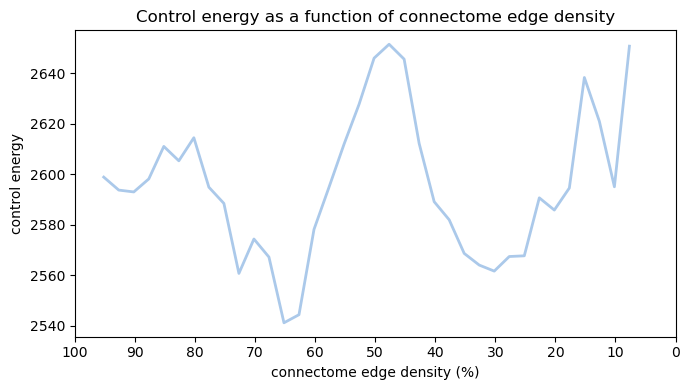

In [24]:
f, ax = plt.subplots(figsize=(7, 4))
blue = [171/255, 201/255, 234/255]
# plot control signals for initial state
ax.plot(A_d_pruned*100, E_prune, linewidth=2, color=blue)
ax.set_title('Control energy as a function of connectome edge density')
ax.set_ylabel('control energy')
ax.set_xlabel('connectome edge density (%)')
ax.set_xticks(np.arange(0, 110, 10))
ax.invert_xaxis()

f.tight_layout()
f.savefig(os.path.join(resultsdir, 'energy_density.svg'), dpi=600, bbox_inches='tight', pad_inches=0.01)
plt.show()

## Null network models

In [25]:
# null networks
centroids = pd.read_csv(os.path.join(datadir, 'pnc_schaefer200_centroids.csv'))  # load coordinates of nodes
centroids.set_index('node_names', inplace=True)
print(centroids.head())

D = distance.pdist(centroids, 'euclidean')  # get euclidean distances between nodes
D = distance.squareform(D)  # reshape to square matrix

            vox_x  vox_y  vox_z
node_names                     
LH_Vis_1      121    149     69
LH_Vis_2      123    174     65
LH_Vis_3      143    166     70
LH_Vis_4      107    164     74
LH_Vis_5      124    192     66


In [26]:
# to paste into manuscript
run = False
if run:
    # extract initial state
    x0 = states == state_labels.index('Vis')  # 'Vis' or 'SalVentAttn'
    x0 = normalize_state(x0)  # normalize

    # extract target state
    xf = states == state_labels.index('Default')
    xf = normalize_state(xf)  # normalize

    # get true control energy
    _, u, _ = get_control_inputs(A_norm=A_norm, T=T, B=B, x0=x0, xf=xf, system=system, rho=rho, S=S)  # get u
    E = integrate_u(u)  # integrate u
    E = np.sum(E)  # get energy

    # run permutation
    n_perms = 5000  # number of permutations

    # containers for null distributions
    energy_null_sp = np.zeros(n_perms)
    energy_null_ssp = np.zeros(n_perms)

    for i in tqdm(np.arange(n_perms)):
        _, Wsp, Wssp = geomsurr(W=A, D=D, seed=i)  # rewire adjacency matrix using geomsurr
        # Wsp is A rewired while preserving spatial embedding and the strength distribution
        # Wssp is A rewired while preserving spatial embedding and the strength sequence
        # this python implementation is included with our toolbox, but if you use these nulls
        # in your own work, please cite:
        #       Roberts et al. NeuroImage (2016), doi:10.1016/j.neuroimage.2015.09.009

        Wsp = matrix_normalization(Wsp, system=system)  # normalize rewired adjacency matrix
        _, u, _ = get_control_inputs(A_norm=Wsp, T=T, B=B, x0=x0, xf=xf, system=system, rho=rho, S=S)  # get u
        e = integrate_u(u)  # integrate null u
        energy_null_sp[i] = np.sum(e)  # store null energy

        Wssp = matrix_normalization(Wssp, system=system)  # normalize rewired adjacency matrix
        _, u, _ = get_control_inputs(A_norm=Wssp, T=T, B=B, x0=x0, xf=xf, system=system, rho=rho, S=S)  # get u
        e = integrate_u(u)  # integrate null u
        energy_null_ssp[i] = np.sum(e)  # store null energy

    # plot
    f, ax = plt.subplots(1, 2, figsize=(7, 3))
    null_plot(observed=E, null=energy_null_sp,
              xlabel='energy null (space & str. dist.)', ax=ax[0])
    null_plot(observed=E, null=energy_null_ssp,
              xlabel='energy null (space & str. seq.)', ax=ax[1])
    f.tight_layout()
    f.savefig(os.path.join(resultsdir, 'energy_network_null.svg'), dpi=600, bbox_inches='tight', pad_inches=0.01)
    plt.show()

In [27]:
# for figures
run = False
if run:
    n_perms = 5000

    transitions = [['Vis', 'Default'],
                   ['Default', 'Vis'],
                   ['SalVentAttn', 'Default'],
                   ['Default', 'SalVentAttn']]
    for transition in transitions:
        # extract initial state
        state_i = transition[0]
        x0 = states == state_labels.index(state_i)
        x0 = normalize_state(x0)

        # extract target state
        state_j = transition[1]
        xf = states == state_labels.index(state_j)
        xf = normalize_state(xf)

        print(state_i, state_j)

        energy_null_sp = np.zeros(n_perms)
        energy_null_ssp = np.zeros(n_perms)

        for i in tqdm(np.arange(n_perms)):
            _, Wsp, Wssp = geomsurr(W=A, D=D, seed=i)

            Wsp = matrix_normalization(Wsp, system=system)  # normalize rewired adjacency matrix
            _, u, _ = get_control_inputs(A_norm=Wsp, T=T, B=B, x0=x0, xf=xf, system=system, rho=rho, S=S)  # get u
            e = integrate_u(u)  # integrate null u
            energy_null_sp[i] = np.sum(e)  # store null energy

            Wssp = matrix_normalization(Wssp, system=system)  # normalize rewired adjacency matrix
            _, u, _ = get_control_inputs(A_norm=Wssp, T=T, B=B, x0=x0, xf=xf, system=system, rho=rho, S=S)  # get u
            e = integrate_u(u)  # integrate null u
            energy_null_ssp[i] = np.sum(e)  # store null energy

        np.save(os.path.join(resultsdir, 'energy_null_sp_{0}_{1}'.format(state_i, state_j)), energy_null_sp)
        np.save(os.path.join(resultsdir, 'energy_null_ssp_{0}_{1}'.format(state_i, state_j)), energy_null_ssp)
else:
    pass

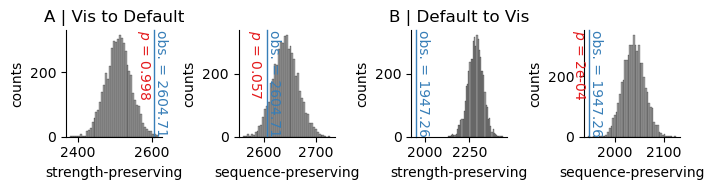

In [28]:
run = True
if run:
    f, ax = plt.subplots(1, 4, figsize=(7, 2))

    # i-->j
    state_i = 'Vis'  # 'Vis' or 'SalVentAttn'
    x0 = states == state_labels.index(state_i)
    x0 = normalize_state(x0)
    state_j = 'Default'
    xf = states == state_labels.index(state_j)
    xf = normalize_state(xf)

    _, u, _ = get_control_inputs(A_norm=A_norm, T=T, B=B, x0=x0, xf=xf, system=system, rho=rho, S=S)  # get u
    E = integrate_u(u)
    E = np.sum(E)

    energy_null_sp = np.load(os.path.join(resultsdir, 'energy_null_sp_{0}_{1}.npy'.format(state_i, state_j)))
    energy_null_ssp = np.load(os.path.join(resultsdir, 'energy_null_ssp_{0}_{1}.npy'.format(state_i, state_j)))

    p_val = get_null_p(E, energy_null_sp, version='reverse', abs=False)
    null_plot(observed=E, null=energy_null_sp, p_val=p_val, xlabel='strength-preserving', ax=ax[0])
    ax[0].set_title('A | {0} to {1}'.format(state_i, state_j))

    p_val = get_null_p(E, energy_null_ssp, version='reverse', abs=False)
    null_plot(observed=E, null=energy_null_ssp, p_val=p_val, xlabel='sequence-preserving', ax=ax[1])

    # j-->i
    state_i = 'Default'
    x0 = states == state_labels.index(state_i)
    x0 = normalize_state(x0)
    state_j = 'Vis'  # 'Vis' or 'SalVentAttn'
    xf = states == state_labels.index(state_j)
    xf = normalize_state(xf)

    _, u, _ = get_control_inputs(A_norm=A_norm, T=T, B=B, x0=x0, xf=xf, system=system, rho=rho, S=S)  # get u
    E = integrate_u(u)
    E = np.sum(E)

    energy_null_sp = np.load(os.path.join(resultsdir, 'energy_null_sp_{0}_{1}.npy'.format(state_i, state_j)))
    energy_null_ssp = np.load(os.path.join(resultsdir, 'energy_null_ssp_{0}_{1}.npy'.format(state_i, state_j)))

    p_val = get_null_p(E, energy_null_sp, version='reverse', abs=False)
    null_plot(observed=E, null=energy_null_sp, p_val=p_val, xlabel='strength-preserving', ax=ax[2])
    ax[2].set_title('B | {0} to {1}'.format(state_i, state_j))

    p_val = get_null_p(E, energy_null_ssp, version='reverse', abs=False)
    null_plot(observed=E, null=energy_null_ssp, p_val=p_val, xlabel='sequence-preserving', ax=ax[3])

    f.tight_layout()
    f.savefig(os.path.join(resultsdir, 'energy_network_null.svg'), dpi=600, bbox_inches='tight', pad_inches=0.01)
    plt.show()